<a id='phase-0'></a>
# Harvesting Meaning from Text: A Quick Demonstration on Word2Vec

--- 
#### Glenn Abastillas | 24 March, 2020

<img src="./images/splash_image.png" style="height: 50%; width: 50%; float: right; margin-left: 1em;" />

This notebook goes over an example implementation of Word2Vec and some existing packages that perform Word2Vec training.

### Contents
  1. [Preliminary Steps](#phase-1) : Loading and preprocessing the text data
      
  2. [Background](#phase-2) : Brief overview on Word2Vec and building the model
      
  3. [Some Examples](#phase-3) : Looking at some example word vectors by similarity
  
  4. [Visualizating Vectors](#phase-4) : Visualizing the model's vectors
  
  5. [Key Takeaways](#section-5) : Things to note and remember

<br>
<br>

<a id='phase-1'></a><a id="section-1"></a></span>

---

<span class='bold'>Section</span> [Top](#phase-1) &bull; [Bottom](#phase-2) &bull; 1.0 Load Packages &bull; [1.1 Visual Inspection](#section-1-1) &bull; [1.2 Slimming Down](#section-1-2) &bull; [1.3 Subsampling](#section-1-3) &bull; [1.4 Encoding Tokens](#section-1-4)

# Preliminary Steps 


## <span class='phase-1'>1.0 Load Packages 
First we import packages and clean the data.

In [18]:
import numpy as np
import pandas as pd
import altair as alt

from string import punctuation
from collections import namedtuple
from nltk.corpus import brown, gutenberg, stopwords
from tqdm.notebook import trange, tqdm
from IPython.core.display import display, HTML

display(HTML('./style/style.html'))
alt.renderers.enable('notebook')
corpus = brown

We will use data from the `gutenberg` corpus and normalize the input data.

In [2]:
title = 'cp01'
sents = corpus.sents(title)
words = corpus.words(title)
tagged = corpus.tagged_words(title)

print(f'Number of sentences: {len(sents):,}')
print(f'Number of words: {len(words):,}')

Number of sentences: 131
Number of words: 2,332


<p class='attention banner'>Parameters, Counts, and Probability Data for Later</p>

In [3]:
sents = [[word.lower() for word in sent] for sent in sents]
words = [word.lower() for word in words]

WORDS, COUNTS = np.unique(words, return_counts=True)  # Constant values for unique words and word counts
PROBS = COUNTS**0.75 / (COUNTS**0.75).sum()  # Frequency of words in corpus (see paper cited)
INDEX = np.arange(WORDS.size)  # Numeric index of all unique words

VOCAB = dict(zip(WORDS, INDEX))  # Mappings from word-to-index
VOCABR = dict(zip(INDEX, WORDS))  # Mappings from index-to-word

<a id='section-1-1'></a>

---
<span class='bold'>Section</span> [Top](#section-1) &bull; [Bottom](#section-2) &bull; [1.0 Load Packages](#section-1) &bull; 1.1 Visual Inspection &bull; [1.2 Slimming Down](#section-1-2) &bull; [1.3 Subsampling](#section-1-3) &bull; [1.4 Encoding Tokens](#section-1-4)

### <span class='phase-1'>1.1 Visual Inspection</span> 

A quick look into our corpus reveals that a handful of sentence lengths dominate this text.

In [4]:
lengths = [len(sent) for sent in sents]
unique = pd.DataFrame(zip(lengths, sents), columns=['tokens', 'sents']).drop_duplicates('tokens')

lengths = pd.DataFrame(lengths, columns=['tokens'])

lengths = lengths['tokens'].value_counts()
lengths = pd.DataFrame(lengths.reset_index())
lengths.columns = ['tokens', 'length']

lengths = lengths.merge(unique)

lengths.sents = lengths.sents.str.join(' ')

<p class='tip banner'>Bar chart shows this distribution</p>

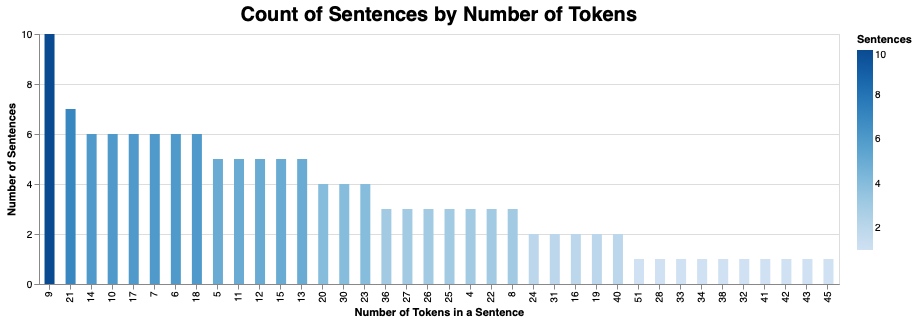

In [5]:
# Visual look at the sentence lengths
chart = alt.Chart(lengths, width=800, height=250).mark_bar(size=10)
chart = chart.encode(x=alt.X('tokens:O', 
                             title='Number of Tokens in a Sentence', 
                             sort=alt.SortField(field='length', order='descending')), 
                     y=alt.Y('length', 
                             title='Number of Sentences'),
                     color=alt.Color('length', title='Sentences'),
                     tooltip='sents')
chart = chart.properties(title='Count of Sentences by Number of Tokens').configure_title(fontSize=20)
chart.interactive()

<a id='section-1-2'></a>

---
<span class='bold'>Section</span> [Top](#section-1) &bull; [Bottom](#section-2) &bull; [1.0 Load Packages](#section-1) &bull; [1.1 Visual Inspection](#section-1-1) &bull; 1.2 Slimming Down &bull; [1.3 Subsampling](#section-1-3) &bull; [1.4 Encoding Tokens](#section-1-4)

### <span class='phase-1'>1.2 Slimming Down</span> 

Next we preprocess the text to get rid of overly frequent words like stopwords. An example of stopwords are shown below. 

<img src='./images/stopwords.jpg' style='height: 15em; width: 15em;' />

In [6]:
# Functions to help us slim down our text
stopwords_ = stopwords.words('english')

def is_stopword(token):
    ''' Check if a specified token is a stopword. '''
    try:
        return token.lower() in stopwords_
    except:
        return False

def is_valid_token(token):
    ''' Check if token is valid, i.e., not a stopword or punctuation '''
    try:
        return token.isalnum() & ~is_stopword(token)
    except:
        return False

def subsample(vocabulary, probs=PROBS, sample_rate=0.001):
    ''' Return the indices of words to be excluded '''
    p_keep = (np.sqrt(probs / sample_rate) + 1) * sample_rate / probs
    p_keep[p_keep >= 1] = 1
    return p_keep

<a id='section-1-3'></a>

---
<span class='bold'>Section</span> [Top](#section-1) &bull; [Bottom](#section-2) &bull; [1.0 Load Packages](#section-1) &bull; [1.1 Visual Inspection](#section-1-1) &bull; [1.2 Slimming Down](#section-1-2) &bull; 1.3 Subsampling &bull; [1.4 Encoding Tokens](#section-1-4)

<!--
<img src="./images/subsample.png" style='float: left; height: 10em; margin-left: 1em; margin-right: 2em; margin-top: 2em;'/>
-->

### <span class='phase-1'>1.3 Subsampling</span> 

Remove overly frequent words that may not contribute much to vector meanings. 
<br>
<br>
$e.g., probability_{keep}(word) < 75\%$.
<br>
<br>
<p class='attention banner'>For more detail on subsampling, see <a href="http://arxiv.org/pdf/1310.4546.pdf" target='blank'>Mikolov, Sutskever, et al.</a> (2013).</p>

In [7]:
keep = subsample(WORDS)
exclude = [word for word in WORDS[keep < 0.75]]

# Apply exclude filter to sentences
sents = [[word for word in sent if (word not in exclude) and is_valid_token(word)] for sent in sents]
print(f'Number of sentences: {len(sents):,}')

Number of sentences: 131


<a id='section-1-4'></a>

---
<span class='bold'>Section</span> [Top](#section-1) &bull; [Bottom](#section-2) &bull; [1.0 Load Packages](#section-1) &bull; [1.1 Visual Inspection](#section-1-1) &bull; [1.2 Slimming Down](#section-1-2) &bull; [1.3 Subsampling](#section-1-3) &bull; 1.4 Encoding Tokens

<!--
<img src="./images/matrix.png" style="float: right; height: 7em; margin-top: 2em; margin-right: 5em;" />
-->

### <span class='phase-1'>1.4 Encoding Tokens</span> 

The last step is to encode our language data from strings into integers so that it can be processed by our machines.

In [8]:
%%time
data = (np.array([VOCAB[token] for token in sent]) for sent in sents)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.1 µs


<p class='tip banner'>Preprocessing complete! Now on to the model. </p>

<a id='phase-2'></a><a id='section-2'></a>

---

<span class='bold'>Section</span> [Top](#phase-1) &bull; [Bottom](#phase-3) &bull; 2.0 Word2Vec &bull; [2.1 From Scratch](#section-2-1) &bull; [2.2 Generate Input](#section-2-2) &bull; [2.3 Algorithm Architecture](#section-2-3) &bull; [2.4 Forward and Backward](#section-2-4) &bull; [2.5 Training](#section-2-5)

# Background 

## <span class='phase-2'>2.0 Word2Vec</span> 

<img src="./images/splash_image_2.png" style="float: right; height: 40%; width: 40%; margin-left: 2em;" />

<h3 class='phase-2'> Word2Vec—What is it?</h3>
<p class='content'><span class='bold'>Word2Vec</span> is a method of representing words as numerical vectors. This representation allows us to improve model efficiency and endows words with numeric properties that capture semantic relationships in text like the image to the right.</p>
<p class='content'>That means that we convert words built from characters to 'words' built from numbers.</p>
    <p class='example'>$word \Rightarrow [0.1,0.7,0.3,0.9,0.3]$</p>
    <p class='example'>$bird \Rightarrow [0.1,0.7,0.8,0.7,0.5]$</p>

---

<h3 class='phase-2'> What are its uses?</h3>
<p class='content'>Because of <span class='bold'>Word2Vec</span>'s uncanny ability to capture hidden patterns in large corpora, <span class='bold'>Word2Vec</span> has many uses for information extraction from a large, unknown text. 
    Here's a short list of applications of <span class='bold'>Word2Vec</span> in documents:</p>

  * Identifying emerging topics in large amounts of text
  * Identifying entities and relationships
  * Developing knowledge resources for other NLP work (e.g., semantic analyses)
 
---
<p class='warning banner'>Make this a list and include Elmo and Fasttext</p>
<h3 class='phase-2'> Other Models</h3>
<p class='content'><span class='bold'>Word2Vec</span> is not the only way to represent lexical items as numeric vectors. Other methods include:</p>
    
  * GloVe
  * Elmo
  * Fasttext
  * TF-IDF


<a id="section-2-1"></a>

---
<span class='bold'>Section</span> [Top](#phase-2) &bull; [Bottom](#phase-3) &bull; [2.0 Word2Vec](#section-2) &bull; 2.1 From Scratch &bull; [2.2 Generate Input](#section-2-2) &bull; [2.3 Algorithm Architecture](#section-2-3) &bull; [2.4 Forward and Backward](#section-2-4) &bull; [2.5 Training](#section-2-5)
<!--
<img src='./images/from_scratch.jpg' style='height: 20em; float: right; padding-right: 3em;' />
-->

### <span class='phase-2'>2.1 From Scratch</span> 

For things example, we will create a Word2Vec language model using the data we preprocessed above. In this section, we will develop a **<a id="skip-gram" style="text-decoration: none; cursor: help;" title="Using the a token to predict its surroundings">Skip-gram</a>** flavored Word2Vec model.

We will:
  * Create Skip-gram windows
  * Create preliminary <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a>


###### Parameters <a id='parameters'></a>
First we define some hyperparameters that we use for training. 

<p class='attention banner'>For more information on setting parameters, see <a href='https://www.aclweb.org/anthology/D14-1162/'>Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing</a>.</p>

In [9]:
parameters = {'window' : 3, 'dimensions' : 100, 'learning_rate' : 0.01, 'epochs' : 100}

<a id="section-2-2"></a>

---
<span class='bold'>Section</span> [Top](#phase-2) &bull; [Bottom](#phase-3) &bull; [2.0 Word2Vec](#section-2) &bull; [2.1 From Scratch](#section-2-1) &bull; 2.2 Generate Input &bull; [2.3 Algorithm Architecture](#section-2-3) &bull; [2.4 Forward and Backward](#section-2-4) &bull; [2.5 Training](#section-2-5)



### <span class='phase-2'>2.2 Generate Input</span> 

We will generate loose <a id='one-hot' style='text-decoration: none; cursor: help;' title='A vector that is comprised of zeros and ones indicating absence or presence of a value'>one-hot vectors</a> that will serve as input and target data when training our model.

First we filter our data to ensure we have sufficient data to window.

In [10]:
%%time

# Make sure data fits within window
data = [sent for sent in data if sent.size >= parameters['window'] + 1]

print(f'Number of sentences in data: {len(data)}')

Number of sentences in data: 95
CPU times: user 2.16 ms, sys: 381 µs, total: 2.54 ms
Wall time: 3.33 ms


Now, we generate our one hot vectors using the `VOCAB` as a model for our vector.

Let's define a few functions to help use generate these data.

In [11]:
Datum = namedtuple('Datum', 'target context'.split())

def one_hot(token, size=WORDS.size):
    ''' Convert an input token into an integer according to a specified reference '''
    vector = np.zeros((1, size))
    vector[0, token] = 1
    return vector

def generate_examples(data, examples=[], size=parameters['window']):
    ''' Create a example data with the structure [(context, targets), ...] '''
    sentences = tqdm(enumerate(data), desc='Generating examples', total=len(data))
    
    for i, sentence in sentences:
        
        for j, token in enumerate(sentence):
            before = max(j - size, 0)
            after = j + size
            skip = j + 1

            context = one_hot(sentence[j])
            targets = np.append(sentence[before:j], sentence[skip:after])
            
            _targets = []
        
            for target in targets:
                _targets.append(one_hot(target))
                
            examples.append((context, _targets))
    
    return examples


Loop through all the sentences to generate `target` and `context` data for training.
<p class='attention banner'>Processing time may vary </p>

In [12]:
examples = generate_examples(data)
print(f'{len(examples)} examples')


847 examples


<a id='section-2-3'></a>

---
<span class='bold'>Section</span> [Top](#phase-2) &bull; [Bottom](#phase-3) &bull; [2.0 Word2Vec](#section-2) &bull; [2.1 From Scratch](#section-2-1) &bull; [2.2 Generate Input](#section-2-2) &bull; 2.3 Algorithm Architecture &bull; [2.4 Forward and Backward](#section-2-4) &bull; [2.5 Training](#section-2-5)


### <span class='phase-2'>2.3 Algorithm Architecture</span> 

These matrices will serve as the layers that surround our `word2vec` layer during training.

<img src='./images/architecture.png' style='height: 50%; width: 50%; margin-bottom; 2em;' />

This cell defines the weight matrices used by the model.

In [13]:
dimensions = parameters['dimensions']
size = WORDS.size

w1 = np.random.random((size, dimensions))
w2 = np.random.random((dimensions, size))

print(f'Dimensions\nWeights 1 {w1.shape}\nWeights 2 {w2.shape}')

Dimensions
Weights 1 (776, 100)
Weights 2 (100, 776)


<a id='section-2-4'></a>

---
<span class='bold'>Section</span> [Top](#phase-2) &bull; [Bottom](#phase-3) &bull; [2.0 Word2Vec](#section-2) &bull; [2.1 From Scratch](#section-2-1) &bull; [2.2 Generate Input](#section-2-2) &bull; [2.3 Algorithm Architecture](#section-2-3) &bull; 2.4 Forward and Backward &bull; [2.5 Training](#section-2-5)

### <span class='phase-2'>2.4 Forward and Backward</span> 

The first part of a two part algorithm defining a <a id='learning-step' style='text-decoration: none; cursor: help;' title='A phase where training data are learned and errors are adjusted throughout the model'>learning step</a>. This algorithm introduces our randomly initialized model to its first evidence of real data to learn from. It then predicts a surrounding vocabulary item from it.

In [14]:
def forward(context, targets, w1=w1, w2=w2):
    ''' Return three matrices corresponding to the prediction, hidden layer, and output '''
    hidden = context @ w1
    output = hidden @ w2
    prediction = softmax(output)
    error = calculate_error(prediction, targets)
    return prediction, error, output, hidden

def backpropagate(error, hidden, context, w1=w1, w2=w2):
    ''' Update weight matrices according to output from forward() '''
    w2_delta = np.outer(hidden, error) * parameters['learning_rate']
    hidden_error = error @ w2.T
    w1_delta = np.outer(context, hidden_error) * parameters['learning_rate']
    
    w1 -= w1_delta
    w2 -= w2_delta

#### 2.4.1 Supporting Functions for Forward and Backpropagate <a id='section-2-4-1'></a>

In [15]:
def softmax(output):
    ''' Return the an array normalized to a probability '''
    e = np.exp(output)
    return e / e.sum()

def calculate_error(prediction, targets):
    ''' Return weights with the summed prediction error '''
    error = [prediction - token for token in targets]
    return np.sum(error, axis=0)

<a id='section-2-5'></a>

---
<span class='bold'>Section</span> [Top](#phase-2) &bull; [Bottom](#phase-3) &bull; [2.0 Word2Vec](#section-2) &bull; [2.1 From Scratch](#section-2-1) &bull; [2.2 Generate Input](#section-2-2) &bull; [2.3 Algorithm Architecture](#section-2-3) &bull; [2.4 Forward and Backward](#section-2-4) &bull; 2.5 Training

### <span class='phase-2'>2.5 Training</span> 

Having both the feed forward and backpropagation algorithms defined, we can now define a training algorithm to learn all training examples for a single <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

In [16]:
def train(examples, w1=w1, w2=w2, parameters=parameters, total=WORDS.size):
    ''' Train the Word2Vec model on our training data to generate meaningful word vectors '''
    
    epochs = trange(parameters['epochs'], desc="Training")

    for epoch in epochs:
        data = tqdm(examples, desc=f'Epoch {epoch}', leave=False)

        for context, targets in data:
            prediction, error, output, hidden = forward(context, targets)
            backpropagate(error, hidden, context)


###### 2.5.1 Run Training <a id='section-2-5-1'></a>

This cell loops through all our training data to demonstrate what happens in one training <a id='epoch' style='text-decoration: none; cursor: help;' title='A complete cycle of learning steps through all training data'>epoch</a>.

<p class='attention banner'>Processing time may vary</p>

In [17]:
%%time
total_loss = train(examples)


CPU times: user 1min 46s, sys: 4.23 s, total: 1min 50s
Wall time: 2min 7s


<a id='phase-3'></a><a id='section-3'></a>

---
<span class='bold'>Section</span> [Top](#phase-2) &bull; [Bottom](#phase-4) &bull; 3.0 Wordsmithing &bull; [3.1 Random Inspection](#section-3-1) &bull; [3.2 Attemping Algebra](#section-3-2)

# Some Examples 

<img src='./images/wordsmith.png' style='float: left; margin-right: 5em; margin-left: 2em; height: 10em;' />

## <span class='phase-3'>3.0 Wordsmithing</span> 

To make use of the learned weights from training, we should define some functions to do things like convert words into vectors and check for similarity between vectors.

In [19]:
def word_vector(token, model=w1):
    ''' Return the word vector corresponding to a token '''
    if isinstance(token, np.ndarray) or isinstance(token, list):
        return token
    if isinstance(token, str):
        token = VOCAB[token]
    return model[token]

def similarity(vector1, vector2):
    ''' Return the cosine similarity score for two tokens input as vectors '''
    vector1, vector2 = word_vector(vector1), word_vector(vector2)
    a = np.dot(vector1, vector2)
    b = np.dot(vector1, vector1)
    c = np.dot(vector2, vector2)
    return a / (np.sqrt(b) * np.sqrt(c))

<a id='section-3-1'></a>

---
<span class='bold'>Section</span> [Top](#phase-3) &bull; [Bottom](#phase-4) &bull; [3.0 Wordsmithing](#section-3) &bull; 3.1 Random Inspection &bull; [3.2 Attemping Algebra](#section-3-2)

### <span class='phase-3'>3.1 Random Inspection</span> 
We inspect randomly selected words for their similarity score where $similarity \in [-1,1]$

In [20]:
v1 = np.random.choice(WORDS)
v2 = np.random.choice(WORDS)

print(f'"{v1}" and "{v2}" have a similarity score of {round(similarity(v1, v2), 3)}')

"flesh" and "rail" have a similarity score of 0.585


<a id='section-3-2'></a>

---
<span class='bold'>Section</span> [Top](#phase-3) &bull; [Bottom](#phase-4) &bull; [3.0 Wordsmithing](#section-3) &bull; [3.1 Random Inspection](#section-3-1) &bull; 3.2 Attemping Algebra

### <span class='phase-3'>3.2 Attempting Algebra</span> 

With our quickly trained model, we can attempt our own $king - man + woman = queen$ equation.

In [21]:
v3 = word_vector(v1) - word_vector(v2)
similarity(v1, v3)

0.44932088893617833

Now we can check similarity of vector 3 with the intended vector.

In [22]:
v4 = 'morning' # Intended vector
similarity(v3, v4)

-0.024268325081965348

<a id='phase-4'></a>


---
<span class='bold'>Section</span> [Top](#phase-3) &bull; [Bottom](#phase-5) &bull; 4.0 Declaring the Models &bull; [4.1 Dimension Reduction](#section-4-1) &bull; [4.2 Vector Space](#section-4-2)

<!--
<img src='./images/data_viz.png' style='float: right; margin-left: 2em;' />
-->

## Data Visualization 

We can visualize our word vectors trained using plotting packages like `matplotlib`, `seaborn`, and others. I make use of the `altair` visualization package.


### <span class='phase-4'>4.0</span> Declaring the Models <a id='section-4'></a>

We will use Principle Component Analysis (PCA) and t-Stochastic Neighbor Embeddings (t-SNE) to convert our high-dimensional data into 2- and 3-dimensional data for visualization.

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca2 = PCA(n_components=2)
pca50 = PCA(n_components=min(50, w1.shape[0]))
tsne = TSNE(n_components=3, perplexity=100)
scale = StandardScaler()

<a id='section-4-1'></a>

---
<span class='bold'>Section</span> [Top](#phase-4) &bull; [Bottom](#phase-5) &bull; [4.0 Declaring the Models](#section-4) &bull; 4.1 Dimension Reduction &bull; [4.2 Vector Space](#section-4-2)

### <span class='phase-4'>4.1 Dimension Reduction</span>
Normalize the vector weights so that $\mu = 0$ and $\sigma = 1$.

In [25]:
scaled_data = scale.fit_transform(w1)

Reduce dimensionality via PCA transform. Create one set of data for visualization and another set of data to feed the t-SNE algorithm.

In [26]:
pca_data_2 = pca2.fit_transform(scaled_data)
pca_data_50 = pca50.fit_transform(scaled_data)

Reduce dimensionality via TSNE transform.

<p class='attention banner'> Results may vary from run to run</p>

In [33]:
%%time
tsne_data = tsne.fit_transform(pca_data_50)

CPU times: user 1min 27s, sys: 1.57 s, total: 1min 28s
Wall time: 25 s


<a id='section-4-2'></a>

---
<span class='bold'>Section</span> [Top](#phase-4) &bull; [Bottom](#phase-5) &bull; [4.0 Declaring the Models](#section-4) &bull; [4.1 Dimension Reduction](#section-4-1) &bull; 4.2 Vector Space

### <span class='phase-4'>4.2 Vector Space</span>

After transforming the high-dimensional data down to 2 and 3 dimensional datasets, we can better visualize what the vectors we trained look like.

In [34]:
current = tsne_data
columns = [f'd{i}' for i in range(current.shape[-1])]
index = [f'{VOCABR[i]}' for i in range(current.shape[0])]

viz_data = pd.DataFrame(tsne_data, columns=columns, index=index).reset_index()
tagged_words = pd.DataFrame(tagged, columns=['index', 'tag'])
viz_data = viz_data.merge(tagged_words, how='left').drop_duplicates()

<p class='tip banner'>Plot the vectors in space</p>

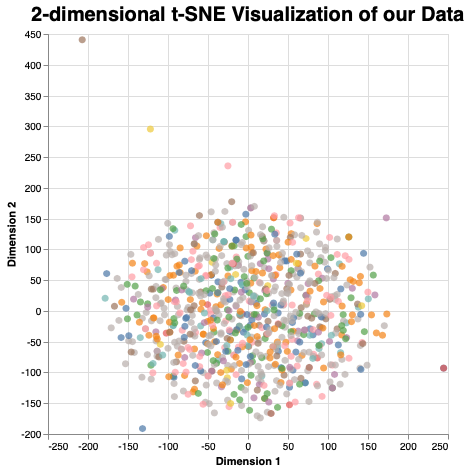

In [35]:
chart = alt.Chart(viz_data, height=400, width=400)

marked1 = chart.mark_circle(size=50)
marked1 = marked1.encode(x=alt.X('d1:Q', title='Dimension 1'), 
                         y=alt.Y('d0:Q', title='Dimension 2'), 
                         tooltip='index', 
                         color=alt.Color('tag', legend=None))
marked1 = marked1.properties(title='2-dimensional t-SNE Visualization of our Data').configure_title(fontSize=20)
marked1.interactive()

<a id='phase-5'></a><a id='section-5'></a>

---
<span class='bold'>Section</span> [Top](#phase-4) &bull; [Bottom](#phase-5) &bull; [5.0 Key Takeaways](#section-5) &bull; [5.1 Closing Notes](#section-5-1)

# Closing <a id='phase-5'></a>

### <span class='phase-5'>5.0 Key Takeaways</span>
<img src='./images/takeaway.jpg' style='float: right; height: 10em; margin-right: 2em;'/>

Here are some main points to remember after this presentation:

  * Words can be converted into mathematical objects
  * Words as mathematical objects can encode and capture deep relationships in the original text
  * Word2Vec is only one way of creating word embeddings

### <span class='phase-5'>5.1 Closing Notes</span> <a id='section-5'></a>

There are existing implementations that already exist that allow you to use Word2Vec technology out of the box.

Examples of these include:
  * SpaCy
  * gensim
  * ELMo
  * fasttext
 

---

References
[1] Test

---

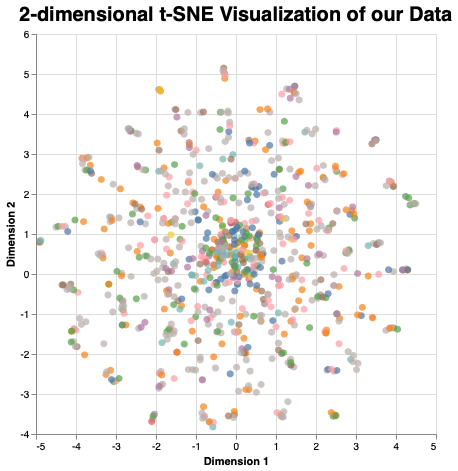

In [236]:
marked = chart.mark_circle(size=50)
marked = marked.encode(x=alt.X('d1:Q', title='Dimension 1'), 
                       y=alt.Y('d0:Q', title='Dimension 2'), 
                       tooltip='index', 
                       color=alt.Color('tag', legend=None))
marked = marked.properties(title='2-dimensional t-SNE Visualization of our Data').configure_title(fontSize=20)
marked.interactive()